# **Catatan**

- Kode program 1 adalah kalian tinggal running kode ini agar dapat melihat training dengan data asli tanpa dibersihkan, kemudian dievaluasi hasilnya dan dicatat. (running sendiri ya, kalau ada error screenshot kirim ke wa saya)
- hasil training dengan data asli (classification non-tuning) dibandingkan dengan hasil training data asli menggunakan hyperparameter tuning
- metric evaluasinya harus ada accuracy, precision, recall, dan f1-score

Kode ini untuk Topik ini:
- Phishing URL Detection Using BERT-Based Transformer Models
Topik Riset:
"Deteksi URL Phishing dengan Model Transformer Berbasis BERT: Studi Kasus Analisis URL dan Email"
Deskripsi:
Model BERT (Bidirectional Encoder Representations from Transformers) digunakan untuk memahami konteks URL atau teks email yang mencurigakan. Model ini dapat menganalisis karakter URL dan teks email untuk membedakan apakah mereka merupakan phishing atau tidak berdasarkan pola yang diidentifikasi dari dataset phishing.
Novelty: Sedang. Meskipun deteksi phishing berbasis URL sudah diteliti cukup luas, penggunaan BERT untuk klasifikasi URL secara mendalam masih relatif baru. Namun, karena banyak model sudah menggunakan BERT untuk analisis teks, tingkat novelty bisa lebih tinggi jika dilakukan kombinasi fitur tambahan seperti analisis perilaku pengguna.
Dataset: Malicious URL Dataset
Dataset ini berisi jutaan URL berbahaya, termasuk yang digunakan untuk phishing. BERT, sebagai model Transformer, dapat digunakan untuk memahami pola karakteristik URL dan memprediksi kemungkinan serangan phishing.
URL: Malicious URL Dataset​(GitHub)


# **Importing Modules and Libraries**

In [ ]:
# Importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from os import path

# Sklearn imports (consolidated)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc
)

# PyTorch imports (consolidated)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.amp import GradScaler, autocast
from torch.optim import AdamW

# Transformers and progress bar (consolidated)
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm.auto import tqdm
import transformers  # for setting logging verbosity


In [ ]:
!pip install transformers tensorflow scikit-learn matplotlib pandas
!pip install transformers


# **Importing Datasets**

Mount Google Drive:

Digunakan untuk mengakses file yang disimpan di Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ls


Mounted at /content/gdrive
gdrive	sample_data


Mengubah direktori kerja:

Ini digunakan untuk berpindah ke folder tempat dataset Anda berada.

In [ ]:
import os
os.chdir("/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset")
!ls


malicious_phish.csv  model_best_fold_2	model_best_fold_4
model_best_fold_1    model_best_fold_3	model_best_fold_5


Memuat dataset:

Dataset **malicious_phish.csv** dimuat ke dalam variabel data.

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')
print("Jumlah data asli:", len(data))
# data = data.sample(frac=0.0001, random_state=42).reset_index(drop=True)

# Mengambil xx% dari data secara acak
# ini sementara dilakukan karena resource yang dimiliki terbatas


Jumlah data asli: 651191


Menampilkan informasi awal tentang data:

Menampilkan 5 baris pertama dari dataset dan informasi tentang tipe data, jumlah entri, dan kolom yang ada di dalam dataset.

In [ ]:
data.head(n=5)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
# Misalkan kolom yang berisi label adalah 'type'
# Menampilkan nilai unik dan jumlah setiap kelas
kelas = data['type'].value_counts()
print(kelas)

# Menampilkan jumlah kelas unik
jumlah_kelas = data['type'].nunique()
print(f"Jumlah kelas unik: {jumlah_kelas}")


type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64
Jumlah kelas unik: 4


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [ ]:
# Dimensions of the datasets after drop '-' in service column
print("(rows, columns):", data.shape)

(rows, columns): (651191, 2)


Ini adalah proses atau tahapan persiapan data yang baik sebelum dilanjutkan ke tahap analisis atau pemodelan.

# **EDA**

In [ ]:
print(data.columns)


Index(['url', 'type'], dtype='object')


In [ ]:
print(data['type'].value_counts())


type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64


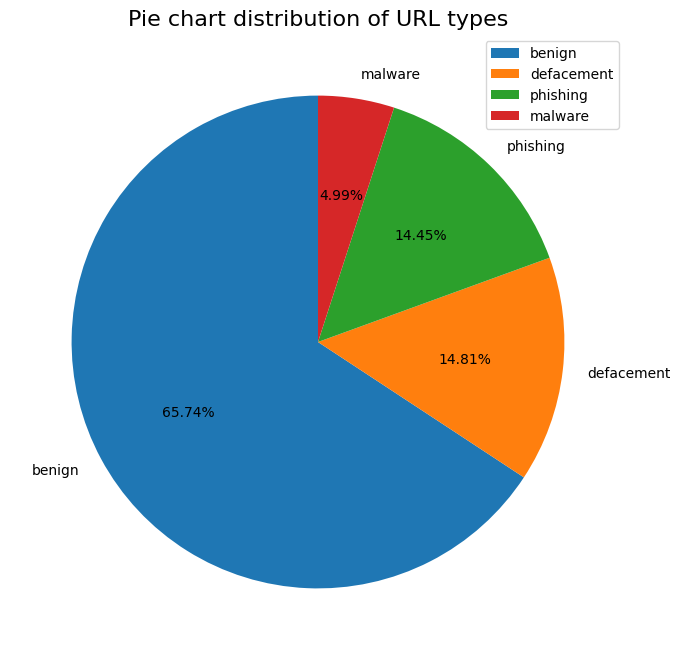

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset

# Hitung distribusi semua label
label_counts = data['type'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%0.2f%%', startangle=90)
plt.title("Pie chart distribution of URL types", fontsize=16)
plt.legend()
plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/plot/Pie_chart_all_classes.png')
plt.show()


<ipython-input-13-5404a76a3c7a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='type', palette='Set2')


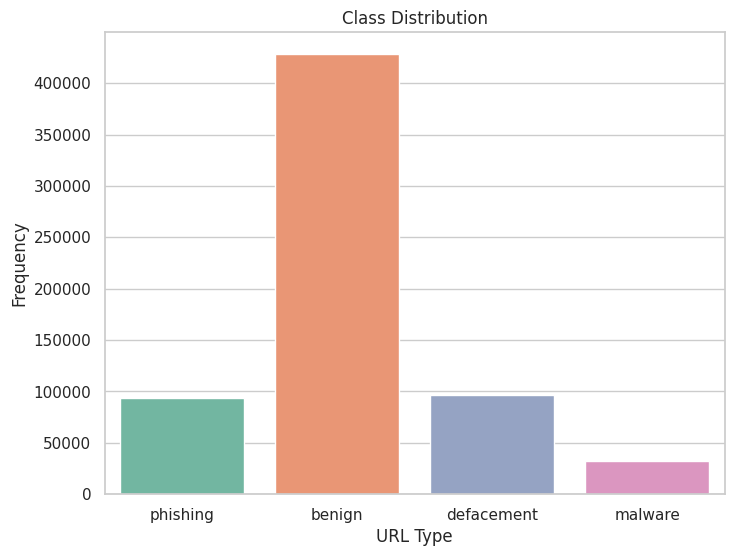

In [ ]:
# Set style for seaborn
sns.set(style='whitegrid')

# 1. Distribusi Kelas
# Visualisasi distribusi kelas pada dataset
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='type', palette='Set2')
plt.title("Class Distribution")
plt.xlabel("URL Type")
plt.ylabel("Frequency")
plt.show()

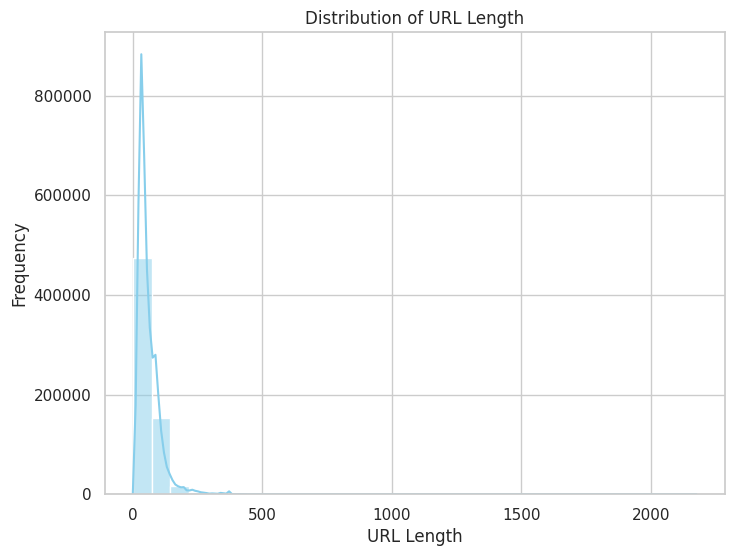

In [ ]:
# 2. Distribusi Panjang URL
# Tambahkan kolom panjang URL
data['url_length'] = data['url'].apply(len)

# Visualisasi distribusi panjang URL
plt.figure(figsize=(8, 6))
sns.histplot(data['url_length'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of URL Length")
plt.xlabel("URL Length")
plt.ylabel("Frequency")
plt.show()

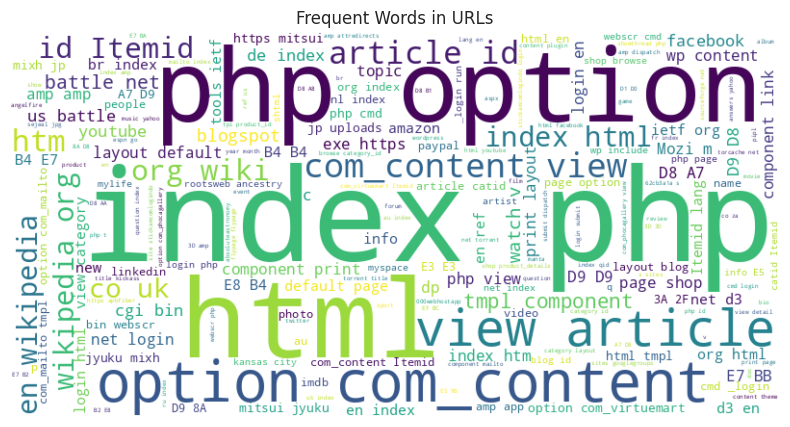

In [ ]:
from wordcloud import WordCloud

# 3. Frekuensi Kata Penting
# Gabungkan semua URL dalam satu string
urls_text = ' '.join(data['url'])

# Generate word cloud dari kata-kata umum dalam URL
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(urls_text)

# Visualisasi word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Frequent Words in URLs")
plt.show()



<ipython-input-16-cc68a72c4d04>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_domains.values, y=top_domains.index, palette='viridis')


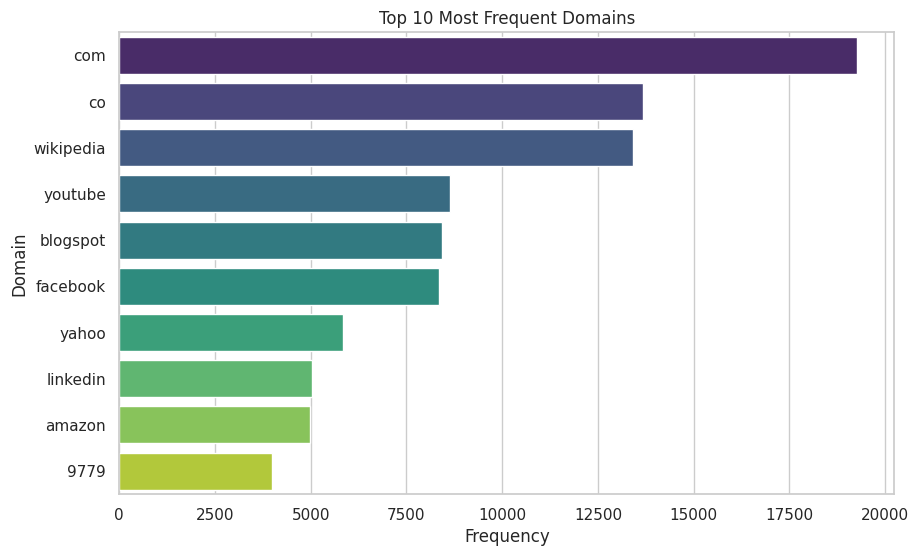

In [ ]:
# Ekstraksi domain utama dari URL dengan penanganan error
def extract_domain(url):
    try:
        # Mengambil bagian domain dari URL
        parts = url.split('//')[-1].split('/')[0].split('.')
        if len(parts) >= 2:
            return parts[-2]
        else:
            return parts[0]  # Jika hanya ada satu bagian, gunakan itu
    except IndexError:
        return None  # Kembalikan None jika terjadi error

# Terapkan fungsi pada kolom URL untuk mendapatkan domain utama
data['domain'] = data['url'].apply(extract_domain)

# Visualisasikan 10 domain yang paling sering muncul
top_domains = data['domain'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_domains.values, y=top_domains.index, palette='viridis')
plt.title("Top 10 Most Frequent Domains")
plt.xlabel("Frequency")
plt.ylabel("Domain")
plt.show()


# **URL Cleaning**

In [ ]:
import re

# 1. Normalisasi URL: Konversi semua URL menjadi huruf kecil
data['cleaned_url'] = data['url'].str.lower()

# 2. Penghapusan Parameter Tak Relevan
# Hapus parameter setelah `?` atau `#`
data['cleaned_url'] = data['cleaned_url'].apply(lambda x: re.sub(r'\?.*|#.*', '', x))

# 3. Penghapusan Tanda Khusus yang Tidak Diperlukan
# Bersihkan elemen seperti `http://`, `https://`, dan `www.`
data['cleaned_url'] = data['cleaned_url'].apply(lambda x: re.sub(r'http://|https://|www\.', '', x))

# 4. Tokenisasi URL
# Pisahkan URL menjadi token berbasis tanda pemisah `/`, `.`, dan `-`
data['tokenized_url'] = data['cleaned_url'].apply(lambda x: re.split(r'[./\-]', x))

# Hapus token kosong akibat pemisahan karakter khusus
data['tokenized_url'] = data['tokenized_url'].apply(lambda x: [token for token in x if token])

# Tampilkan beberapa contoh hasil cleaning
print("Contoh URL Asli dan URL Setelah Cleaning:")
print(data[['url', 'cleaned_url', 'tokenized_url']].head())

# Simpan dataset yang sudah dibersihkan ke dalam file baru jika diperlukan
data.to_csv('malicious_phish_cleaned.csv', index=False)

Contoh URL Asli dan URL Setelah Cleaning:
                                                 url  \
0                                   br-icloud.com.br   
1                mp3raid.com/music/krizz_kaliko.html   
2                    bopsecrets.org/rexroth/cr/1.htm   
3  http://www.garage-pirenne.be/index.php?option=...   
4  http://adventure-nicaragua.net/index.php?optio...   

                           cleaned_url  \
0                     br-icloud.com.br   
1  mp3raid.com/music/krizz_kaliko.html   
2      bopsecrets.org/rexroth/cr/1.htm   
3          garage-pirenne.be/index.php   
4    adventure-nicaragua.net/index.php   

                               tokenized_url  
0                      [br, icloud, com, br]  
1  [mp3raid, com, music, krizz_kaliko, html]  
2     [bopsecrets, org, rexroth, cr, 1, htm]  
3          [garage, pirenne, be, index, php]  
4    [adventure, nicaragua, net, index, php]  


# **DATA SPLITTING**

Jumlah data filtered: 522214
Jumlah data trim: 522


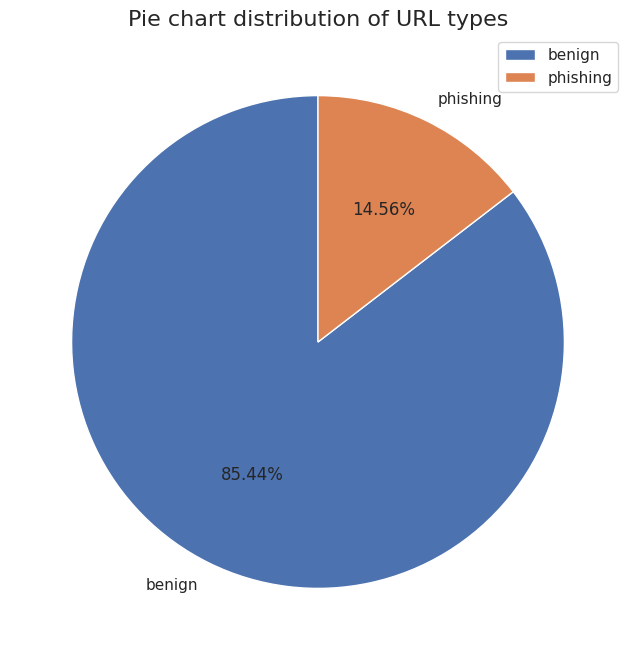

Ukuran set pelatihan: 365
Ukuran set pengujian: 157


In [ ]:
# # Memisahkan fitur dan label
# X_multi = data['url']  # Fitur: URL
# y_multi = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})  # Mengonversi label ke numerik

# Filter the data to keep only benign and phishing types
data_filtered = data[data['type'].isin(['benign', 'phishing'])]
print("Jumlah data filtered:", len(data_filtered))

data_filtered = data_filtered.sample(frac=0.001, random_state=42).reset_index(drop=True)
print("Jumlah data trim:", len(data_filtered))

# Hitung distribusi semua label
label_counts = data_filtered['type'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%0.2f%%', startangle=90)
plt.title("Pie chart distribution of URL types", fontsize=16)
plt.legend()
plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/plot/Pie_chart_filter.png')
plt.show()

# Define features and labels
X_multi = data_filtered['url']  # Fitur: URL
y_multi = data_filtered['type'].map({'benign': 0, 'phishing': 1})  # Mengonversi label ke numerik


# Membagi data menjadi set pelatihan (70%) dan set pengujian (30%)
# X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42)

# Menampilkan informasi tentang ukuran set
print(f'Ukuran set pelatihan: {X_train.shape[0]}')
print(f'Ukuran set pengujian: {X_test_bin.shape[0]}')


# **Data Balancing with SMOTE**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE

# Tokenisasi URL menjadi fitur numerik
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)

# Lakukan SMOTE pada data training
smote = SMOTE(random_state=42)
X_train_bin, y_train_bin = smote.fit_resample(X_train_vectorized, y_train)

# Konversi hasil SMOTE ke DataFrame jika diperlukan
# X_resampled_df = pd.DataFrame(X_resampled.toarray(), columns=vectorizer.get_feature_names_out())
# y_resampled_df = pd.Series(y_resampled)

# Tampilkan ukuran dataset setelah SMOTE
print(f'Ukuran set pelatihan setelah SMOTE: {X_train_bin.shape[0]}')


Ukuran set pelatihan setelah SMOTE: 632


#2. TRANSFORMER "BERT"**

# **CLASSIFICATION Non-Tuning**

## tes0

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# import matplotlib.pyplot as plt
# import seaborn as sns
# from torch.cuda.amp import GradScaler, autocast

# # Initialize GradScaler
# scaler = torch.amp.GradScaler()

# # 1. Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')
# data = data.sample(frac=0.25, random_state=1)  # random_state untuk hasil yang konsisten

# # Memisahkan fitur dan label
# X = data['url']  # Fitur: URL
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})  # Mengonversi label ke numerik

# # 2. Initialize BERT tokenizer with clean_up_tokenization_spaces set
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# # 3. KFold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=50)
# all_accuracy, all_f1_scores = [], []
# conf_matrix_list = []
# average_train_losses = []  # List to store average train losses for plotting
# average_val_accuracies = []  # List to store validation accuracies for plotting

# for fold, (train_index, val_index) in enumerate(kf.split(X)):
#     print(f'Fold {fold + 1}')

#     # Split data
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # Tokenization and tensor creation
#     train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
#     val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt')

#     # Convert labels to tensors
#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     # Create DataLoader
#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

#     # Initialize BERT model
#     model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(y.unique()))
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     model.to(device)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

#     # Early stopping setup
#     best_accuracy = 0
#     patience, trigger_times = 5, 0

#     # Train the model
#     num_epochs = 3
#     train_losses = []
#     val_accuracies = []

#     for epoch in range(num_epochs):
#         model.train()
#         epoch_loss = 0
#         for batch in train_loader:
#             optimizer.zero_grad()
#             input_ids, attention_mask, labels = batch
#             input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

#             with torch.amp.autocast(device_type=device):
#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             epoch_loss += loss.item()

#         avg_loss = epoch_loss / len(train_loader)
#         train_losses.append(avg_loss)

#         # Validate the model
#         model.eval()
#         with torch.no_grad():
#             val_input_ids = val_encodings['input_ids'].to(device)
#             val_attention_mask = val_encodings['attention_mask'].to(device)
#             outputs = model(val_input_ids, attention_mask=val_attention_mask)
#             y_pred = torch.argmax(outputs.logits, dim=1)

#         accuracy = accuracy_score(y_val, y_pred.cpu())
#         val_accuracies.append(accuracy)

#         # Save the best model
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold + 1}')
#             trigger_times = 0
#         else:
#             trigger_times += 1

#         if trigger_times >= patience:
#             print(f'Early stopping triggered at epoch {epoch + 1}')
#             break

#     # Metrics calculation
#     conf_matrix = confusion_matrix(y_val, y_pred.cpu())
#     conf_matrix_list.append(conf_matrix)
#     all_accuracy.append(accuracy)

#     f1 = f1_score(y_val, y_pred.cpu(), average='weighted')
#     all_f1_scores.append(f1)

#     # Print results for the current fold
#     print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')
#     print(f'F1 Score for fold {fold + 1}: {f1:.4f}')
#     cls_report = classification_report(y_val, y_pred.cpu(), target_names=['benign', 'defacement', 'phishing', 'malware'])
#     print(cls_report)

#     # Store average loss and accuracy for plotting
#     average_train_losses.append(train_losses)
#     average_val_accuracies.append(val_accuracies)

#     # Plot confusion matrix for the current fold
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#                 xticklabels=['benign', 'defacement', 'phishing', 'malware'], yticklabels=['benign', 'defacement', 'phishing', 'malware'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for Fold {fold + 1}')
#     plt.show()

# # 4. Average Metrics Across All Folds
# print(f'Average Accuracy: {np.mean(all_accuracy) * 100:.2f}%')
# print(f'Average F1 Score: {np.mean(all_f1_scores):.4f}')

# # 5. Plot the Average Confusion Matrix
# average_conf_matrix = np.mean(conf_matrix_list, axis=0)

# plt.figure(figsize=(8, 6))
# sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#             xticklabels=['benign', 'defacement', 'phishing', 'malware'], yticklabels=['benign', 'defacement', 'phishing', 'malware'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Average Confusion Matrix Across Folds')
# plt.show()

# # 6. Analysis of Results
# print("Hasil Deteksi Pola Enkripsi Ransomware:")
# for i, (acc, f1) in enumerate(zip(all_accuracy, all_f1_scores)):
#     print(f'Fold {i + 1}: Akurasi = {acc * 100:.2f}%, F1 Score = {f1:.4f}')

# # 7. Plot Loss and Accuracy for Each Fold
# for fold in range(len(average_train_losses)):
#     plt.figure(figsize=(12, 5))

#     # Grafik Loss
#     plt.subplot(1, 2, 1)
#     plt.plot(average_train_losses[fold], label='Training Loss', marker='o')
#     plt.title(f'Training Loss for Fold {fold + 1}')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid()

#     # Grafik Akurasi
#     plt.subplot(1, 2, 2)
#     plt.plot(average_val_accuracies[fold], label='Validation Accuracy', marker='o')
#     plt.title(f'Validation Accuracy for Fold {fold + 1}')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.grid()

#     plt.tight_layout()
#     plt.show()


In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from transformers import BertTokenizer, BertForSequenceClassification
# import matplotlib.pyplot as plt
# import seaborn as sns
# from torch.amp import GradScaler, autocast
# from torch.optim import AdamW  # Using PyTorch's AdamW instead of transformers.optimization

# # Initialize gradient scaler with updated syntax
# scaler = GradScaler('cuda')

# # 1. Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')
# data = data.sample(frac=0.25, random_state=1)

# # Separate features and labels
# X = data['url']
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})

# # 2. Initialize BERT Tokenizer with clean_up_tokenization_spaces explicitly set
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# # 3. KFold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=50)
# all_accuracy, all_f1_scores = [], []
# conf_matrix_list = []
# average_train_losses = []
# average_val_accuracies = []

# for fold, (train_index, val_index) in enumerate(kf.split(X)):
#     print(f'Fold {fold + 1}')

#     # Split data
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # Tokenization with explicit padding and truncation settings
#     train_encodings = tokenizer(
#         list(X_train),
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )
#     val_encodings = tokenizer(
#         list(X_val),
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     # Convert labels to tensors
#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     # Create DataLoader
#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

#     # Initialize BERT model
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y.unique()),
#         problem_type="single_label_classification"
#     )
#     model.to(device)

#     # Initialize optimizer using PyTorch's AdamW (removed no_deprecation_warning parameter)
#     optimizer = AdamW(model.parameters(), lr=5e-5)

#     # Early stopping setup
#     best_accuracy = 0
#     patience, trigger_times = 5, 0

#        # Training loop
#     num_epochs = 3
#     train_losses = []
#     val_accuracies = []

#     for epoch in range(num_epochs):
#         model.train()
#         epoch_loss = 0
#         batch_count = 0

#         for batch in train_loader:
#             # Clear gradients at the start of each batch
#             optimizer.zero_grad(set_to_none=True)

#             try:
#                 # Move batch to device and handle potential CUDA out of memory
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 # Forward pass with gradient scaling
#                 with autocast(device_type='cuda', dtype=torch.float16):
#                     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                     loss = outputs.loss

#                 # Backward pass with gradient scaling
#                 scaler.scale(loss).backward()

#                 # Optimize and update scaler
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()

#                 # Accumulate loss
#                 current_loss = loss.item()
#                 epoch_loss += current_loss
#                 batch_count += 1

#                 # Print progress every 10 batches
#                 if batch_count % 10 == 0:
#                     print(f'Epoch {epoch+1}, Batch {batch_count}, Loss: {current_loss:.4f}')

#                 # Clear memory
#                 del outputs, loss
#                 torch.cuda.empty_cache()

#             except RuntimeError as e:
#                 if "out of memory" in str(e):
#                     print('| WARNING: ran out of memory, skipping batch')
#                     if torch.cuda.is_available():
#                         torch.cuda.empty_cache()
#                     continue
#                 else:
#                     raise e

#         # Calculate average loss for the epoch
#         avg_loss = epoch_loss / max(batch_count, 1)  # Prevent division by zero
#         train_losses.append(avg_loss)
#         print(f'Epoch {epoch+1} completed, Average Loss: {avg_loss:.4f}')

#         # Validation step
#         model.eval()
#         val_predictions = []
#         val_labels = []

#         with torch.no_grad():
#             # Process validation data in smaller chunks
#             batch_size = 32  # Smaller batch size for validation
#             for i in range(0, len(val_encodings['input_ids']), batch_size):
#                 batch_end = min(i + batch_size, len(val_encodings['input_ids']))
#                 val_batch_input_ids = val_encodings['input_ids'][i:batch_end].to(device)
#                 val_batch_attention_mask = val_encodings['attention_mask'][i:batch_end].to(device)

#                 outputs = model(val_batch_input_ids, attention_mask=val_batch_attention_mask)
#                 batch_predictions = torch.argmax(outputs.logits, dim=1)

#                 val_predictions.extend(batch_predictions.cpu().numpy())

#                 # Clear memory
#                 del outputs, batch_predictions
#                 torch.cuda.empty_cache()

#         # Calculate accuracy
#         accuracy = accuracy_score(y_val, val_predictions)
#         val_accuracies.append(accuracy)
#         print(f'Validation Accuracy: {accuracy:.4f}')

#         # Model saving and early stopping
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold + 1}')
#             trigger_times = 0
#         else:
#             trigger_times += 1

#         if trigger_times >= patience:
#             print(f'Early stopping triggered at epoch {epoch + 1}')
#             break

#     # Metrics calculation
#     conf_matrix = confusion_matrix(y_val, y_pred.cpu())
#     conf_matrix_list.append(conf_matrix)
#     all_accuracy.append(accuracy)

#     f1 = f1_score(y_val, y_pred.cpu(), average='weighted')
#     all_f1_scores.append(f1)

#     # Print results
#     print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')
#     print(f'F1 Score for fold {fold + 1}: {f1:.4f}')
#     cls_report = classification_report(y_val, y_pred.cpu(),
#                                     target_names=['benign', 'defacement', 'phishing', 'malware'])
#     print(cls_report)

#     # Store metrics for plotting
#     average_train_losses.append(train_losses)
#     average_val_accuracies.append(val_accuracies)

#     # Plot confusion matrix
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#                 xticklabels=['benign', 'defacement', 'phishing', 'malware'],
#                 yticklabels=['benign', 'defacement', 'phishing', 'malware'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for Fold {fold + 1}')
#     plt.show()



## Tes1

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from transformers import BertTokenizer, BertForSequenceClassification
# import matplotlib.pyplot as plt
# import seaborn as sns
# from torch.amp import GradScaler, autocast
# from torch.optim import AdamW
# from tqdm.auto import tqdm  # Import tqdm for progress bars

# # Initialize gradient scaler with updated syntax
# scaler = GradScaler('cuda')

# # 1. Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')
# data = data.sample(frac=0.25, random_state=1)

# # Separate features and labels
# X = data['url']
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})

# # 2. Initialize BERT Tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# # 3. KFold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=50)
# all_accuracy, all_f1_scores = [], []
# conf_matrix_list = []
# average_train_losses = []
# average_val_accuracies = []

# # Progress bar for folds
# for fold, (train_index, val_index) in enumerate(tqdm(kf.split(X), total=5, desc='Folds')):
#     print(f'\nFold {fold + 1}')

#     # Split data
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # Progress bar for tokenization
#     print("Tokenizing training data...")
#     train_encodings = tokenizer(
#         list(tqdm(X_train)),
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     print("Tokenizing validation data...")
#     val_encodings = tokenizer(
#         list(tqdm(X_val)),
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     # Convert labels to tensors
#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     # Create DataLoader with increased batch size
#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Increased batch size to 64

#     # Initialize BERT model
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y.unique()),
#         problem_type="single_label_classification"
#     )
#     model.to(device)

#     # Initialize optimizer
#     optimizer = AdamW(model.parameters(), lr=5e-5)

#     # Early stopping setup
#     best_accuracy = 0
#     patience, trigger_times = 5, 0

#     # Training loop
#     num_epochs = 3
#     train_losses = []
#     val_accuracies = []

#     # Progress bar for epochs
#     for epoch in tqdm(range(num_epochs), desc='Epochs'):
#         model.train()
#         epoch_loss = 0
#         batch_count = 0

#         # Progress bar for batches
#         pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
#         for batch in pbar:
#             optimizer.zero_grad(set_to_none=True)

#             try:
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 with autocast(device_type='cuda', dtype=torch.float16):
#                     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                     loss = outputs.loss

#                 scaler.scale(loss).backward()

#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()

#                 current_loss = loss.item()
#                 epoch_loss += current_loss
#                 batch_count += 1

#                 # Update progress bar description with current loss
#                 pbar.set_postfix({'loss': f'{current_loss:.4f}'})

#                 # Print progress every 10 batches
#                 if batch_count % 500 == 0:
#                     print(f'Epoch {epoch+1}, Batch {batch_count}, Loss: {current_loss:.4f}')

#                 del outputs, loss
#                 torch.cuda.empty_cache()

#             except RuntimeError as e:
#                 if "out of memory" in str(e):
#                     print('| WARNING: ran out of memory, skipping batch')
#                     if torch.cuda.is_available():
#                         torch.cuda.empty_cache()
#                     continue
#                 else:
#                     raise e

#         avg_loss = epoch_loss / max(batch_count, 1)
#         train_losses.append(avg_loss)
#         print(f'Epoch {epoch+1} completed, Average Loss: {avg_loss:.4f}')

#         # Validation step
#         model.eval()
#         val_predictions = []

#         with torch.no_grad():
#             # Progress bar for validation
#             for i in tqdm(range(0, len(val_encodings['input_ids']), 64), desc='Validating'):  # Increased batch size to 64
#                 batch_end = min(i + 64, len(val_encodings['input_ids']))
#                 val_batch_input_ids = val_encodings['input_ids'][i:batch_end].to(device)
#                 val_batch_attention_mask = val_encodings['attention_mask'][i:batch_end].to(device)

#                 outputs = model(val_batch_input_ids, attention_mask=val_batch_attention_mask)
#                 batch_predictions = torch.argmax(outputs.logits, dim=1)

#                 val_predictions.extend(batch_predictions.cpu().numpy())

#                 del outputs, batch_predictions
#                 torch.cuda.empty_cache()

#         # Calculate metrics
#         accuracy = accuracy_score(y_val, val_predictions)
#         val_accuracies.append(accuracy)
#         print(f'Validation Accuracy: {accuracy:.4f}')

#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold + 1}')
#             trigger_times = 0
#         else:
#             trigger_times += 1

#         if trigger_times >= patience:
#             print(f'Early stopping triggered at epoch {epoch + 1}')
#             break

#     # Calculate final metrics
#     y_pred = torch.tensor(val_predictions)
#     conf_matrix = confusion_matrix(y_val, y_pred.cpu())
#     conf_matrix_list.append(conf_matrix)
#     all_accuracy.append(accuracy)

#     f1 = f1_score(y_val, y_pred.cpu(), average='weighted')
#     all_f1_scores.append(f1)

#     # Print results
#     print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')
#     print(f'F1 Score for fold {fold + 1}: {f1:.4f}')
#     cls_report = classification_report(y_val, y_pred.cpu(),
#                                     target_names=['benign', 'defacement', 'phishing', 'malware'])
#     print(cls_report)

#     # Store metrics
#     average_train_losses.append(train_losses)
#     average_val_accuracies.append(val_accuracies)

#     # Plot confusion matrix
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#                 xticklabels=['benign', 'defacement', 'phishing', 'malware'],
#                 yticklabels=['benign', 'defacement', 'phishing', 'malware'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for Fold {fold + 1}')
#     plt.show()

## tes2

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from transformers import BertTokenizer, BertForSequenceClassification
# import matplotlib.pyplot as plt
# import seaborn as sns
# from torch.amp import GradScaler, autocast
# from torch.optim import AdamW

# # Print hyperparameters
# print("Using default hyperparameters: nhead=8, d_model=256, dropout=0.1, lr=5e-5, batch_size=32")

# # Initialize gradient scaler
# scaler = GradScaler('cuda')

# # 1. Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')
# data = data.sample(frac=0.25, random_state=1)

# # Separate features and labels
# X = data['url']
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})

# # Initialize BERT Tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# # KFold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=50)
# num_epochs = 3

# for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
#     print(f"\nFold {fold}/5")

#     # Split data
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # Tokenization
#     # Progress bar for tokenization
#     print("Tokenizing training data...")
#     train_encodings = tokenizer(
#         list(tqdm(X_train)),
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     print("Tokenizing validation data...")
#     val_encodings = tokenizer(
#         list(tqdm(X_val)),
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     # Convert labels to tensors
#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     # Create DataLoader
#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#     # Initialize model
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y.unique()),
#         problem_type="single_label_classification"
#     )
#     model.to(device)

#     # Initialize optimizer
#     optimizer = AdamW(model.parameters(), lr=5e-5)

#     # Training variables
#     best_accuracy = 0
#     best_val_loss = float('inf')

#     def compute_validation_metrics():
#         model.eval()
#         total_val_loss = 0
#         val_predictions = []

#         with torch.no_grad():
#             for i in range(0, len(val_encodings['input_ids']), 32):
#                 batch_end = min(i + 32, len(val_encodings['input_ids']))
#                 val_batch_input_ids = val_encodings['input_ids'][i:batch_end].to(device)
#                 val_batch_attention_mask = val_encodings['attention_mask'][i:batch_end].to(device)
#                 val_batch_labels = y_val_tensor[i:batch_end].to(device)

#                 outputs = model(val_batch_input_ids,
#                               attention_mask=val_batch_attention_mask,
#                               labels=val_batch_labels)

#                 total_val_loss += outputs.loss.item()
#                 batch_predictions = torch.argmax(outputs.logits, dim=1)
#                 val_predictions.extend(batch_predictions.cpu().numpy())

#                 del outputs, batch_predictions
#                 torch.cuda.empty_cache()

#         val_loss = total_val_loss / (len(val_encodings['input_ids']) / 32)
#         accuracy = accuracy_score(y_val, val_predictions)
#         f1 = f1_score(y_val, val_predictions, average='weighted')

#         return val_loss, accuracy, f1, val_predictions

#     # Training loop
#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0
#         batch_count = 0

#         for batch in train_loader:
#             optimizer.zero_grad(set_to_none=True)

#             try:
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 with autocast(device_type='cuda', dtype=torch.float16):
#                     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                     loss = outputs.loss

#                 scaler.scale(loss).backward()
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()

#                 total_train_loss += loss.item()
#                 batch_count += 1

#                 del outputs, loss
#                 torch.cuda.empty_cache()

#             except RuntimeError as e:
#                 if "out of memory" in str(e):
#                     print('| WARNING: ran out of memory, skipping batch')
#                     if torch.cuda.is_available():
#                         torch.cuda.empty_cache()
#                     continue
#                 else:
#                     raise e

#         # Calculate average training loss
#         avg_train_loss = total_train_loss / batch_count

#         # Compute validation metrics
#         val_loss, accuracy, f1, val_predictions = compute_validation_metrics()

#         # Print progress
#         print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {avg_train_loss:.4f}, "
#               f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy*100:.2f}%, "
#               f"F1 Score: {f1:.4f}")

#         # Save best model
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold}')
#             print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

#     # After fold completion, compute final confusion matrix
#     _, _, _, final_predictions = compute_validation_metrics()
#     conf_matrix = confusion_matrix(y_val, final_predictions)

#     # Plot confusion matrix
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#                 xticklabels=['benign', 'defacement', 'phishing', 'malware'],
#                 yticklabels=['benign', 'defacement', 'phishing', 'malware'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for Fold {fold}')
#     plt.show()

## tes3

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from transformers import BertTokenizer, BertForSequenceClassification
# import matplotlib.pyplot as plt
# import seaborn as sns
# from torch.amp import GradScaler, autocast
# from torch.optim import AdamW
# from tqdm.auto import tqdm

# # Print hyperparameters
# print("Using default hyperparameters: nhead=8, d_model=256, dropout=0.1, lr=5e-5, batch_size=64")

# # Initialize gradient scaler
# scaler = GradScaler('cuda')

# # 1. Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')
# data = data.sample(frac=0.1, random_state=1)

# # Separate features and labels
# X = data['url']
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})

# # Initialize BERT Tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# # KFold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# num_epochs = 3

# # Progress bar for folds
# for fold, (train_index, val_index) in enumerate(tqdm(kf.split(X), total=5, desc='Folds', position=0), 1):
#     print(f"\nFold {fold}/5")

#     # Split data
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # Progress bar for train tokenization
#     print("Tokenizing training data...")
#     train_texts = list(X_train)
#     train_encodings = tokenizer(
#         [text for text in tqdm(train_texts, desc='Train Tokenization', position=1)],
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     # Progress bar for validation tokenization
#     print("Tokenizing validation data...")
#     val_texts = list(X_val)
#     val_encodings = tokenizer(
#         [text for text in tqdm(val_texts, desc='Val Tokenization', position=1)],
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     # Convert labels to tensors
#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     # Create DataLoader
#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

#     # Initialize model
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y.unique()),
#         problem_type="single_label_classification"
#     )
#     model.to(device)

#     # Initialize optimizer
#     optimizer = AdamW(model.parameters(), lr=5e-5)

#     # Training variables
#     best_accuracy = 0
#     best_val_loss = float('inf')

#     def compute_validation_metrics():
#         model.eval()
#         total_val_loss = 0
#         val_predictions = []

#         # Progress bar for validation batches
#         val_iterator = range(0, len(val_encodings['input_ids']), 64)
#         with torch.no_grad():
#             for i in tqdm(val_iterator, desc='Validation', position=2, leave=False):
#                 batch_end = min(i + 64, len(val_encodings['input_ids']))
#                 val_batch_input_ids = val_encodings['input_ids'][i:batch_end].to(device)
#                 val_batch_attention_mask = val_encodings['attention_mask'][i:batch_end].to(device)
#                 val_batch_labels = y_val_tensor[i:batch_end].to(device)

#                 outputs = model(val_batch_input_ids,
#                               attention_mask=val_batch_attention_mask,
#                               labels=val_batch_labels)

#                 total_val_loss += outputs.loss.item()
#                 batch_predictions = torch.argmax(outputs.logits, dim=1)
#                 val_predictions.extend(batch_predictions.cpu().numpy())

#                 del outputs, batch_predictions
#                 torch.cuda.empty_cache()

#         val_loss = total_val_loss / (len(val_encodings['input_ids']) / 64)
#         accuracy = accuracy_score(y_val, val_predictions)
#         f1 = f1_score(y_val, val_predictions, average='weighted')

#         return val_loss, accuracy, f1, val_predictions

#     # Training loop with progress bar for epochs
#     for epoch in tqdm(range(num_epochs), desc='Epochs', position=1):
#         model.train()
#         total_train_loss = 0
#         batch_count = 0

#         # Progress bar for batches
#         train_iterator = tqdm(train_loader, desc=f'Training batches', position=2, leave=False)
#         for batch in train_iterator:
#             optimizer.zero_grad(set_to_none=True)

#             try:
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 with autocast(device_type='cuda', dtype=torch.float16):
#                     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                     loss = outputs.loss

#                 scaler.scale(loss).backward()
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()

#                 current_loss = loss.item()
#                 total_train_loss += current_loss
#                 batch_count += 1

#                 # Update progress bar description with current loss
#                 train_iterator.set_description(f'Training (loss: {current_loss:.4f})')

#                 del outputs, loss
#                 torch.cuda.empty_cache()

#             except RuntimeError as e:
#                 if "out of memory" in str(e):
#                     print('| WARNING: ran out of memory, skipping batch')
#                     if torch.cuda.is_available():
#                         torch.cuda.empty_cache()
#                     continue
#                 else:
#                     raise e

#         # Calculate average training loss
#         avg_train_loss = total_train_loss / batch_count

#         # Compute validation metrics
#         val_loss, accuracy, f1, val_predictions = compute_validation_metrics()

#         # Print progress
#         print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {avg_train_loss:.4f}, "
#               f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy*100:.2f}%, "
#               f"F1 Score: {f1:.4f}")

#         # Save best model
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold}')
#             print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

#     # After fold completion, compute final confusion matrix
#     _, _, _, final_predictions = compute_validation_metrics()
#     conf_matrix = confusion_matrix(y_val, final_predictions)

#     # Plot confusion matrix
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#                 xticklabels=['benign', 'defacement', 'phishing', 'malware'],
#                 yticklabels=['benign', 'defacement', 'phishing', 'malware'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for Fold {fold}')
#     plt.show()

## tes4

### 4a

In [ ]:
# # Initialize gradient scaler
# scaler = GradScaler('cuda')

# # # K-Fold dan Epoch
# k_folds = 5
# num_epochs = 3

# # # Hyperparameters
# # input_dim = X_train_bin.shape[1]
# # num_classes = len(class_names)
# # nhead = 8
# # d_model = 256
# # dropout = 0.1
# lr = 5e-5
# batch_size = 64

# model_dir = './Model/Default'
# os.makedirs(model_dir, exist_ok=True)

# # Assume you have already split the data into training and testing sets
# # Using X_train_bin, X_test_bin, y_train_bin, y_test_bin directly from your earlier split

# # Initialize BERT Tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# # KFold Cross-Validation
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# # num_epochs = 3
# #X_train_bin, X_test_bin, y_train_bin, y_test_bin

# # Initialize lists for storing metrics across all folds
# all_labels = []
# all_preds = []
# fold_results = []
# # Progress bar for folds
# for fold, (train_index, val_index) in enumerate(tqdm(kf.split(X_train_bin), total=5, desc='Folds', position=0), 1):
#     print(f"Fold {fold + 1}/{k_folds}")

#     # Split data
#     X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
#     y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

#     # Progress bar for train tokenization
#     print("Tokenizing training data...")
#     train_texts = list(X_train)
#     train_encodings = tokenizer(
#         [text for text in tqdm(train_texts, desc='Train Tokenization', position=1)],
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     # Progress bar for validation tokenization
#     print("Tokenizing validation data...")
#     val_texts = list(X_val)
#     val_encodings = tokenizer(
#         [text for text in tqdm(val_texts, desc='Val Tokenization', position=1)],
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     # Convert labels to tensors
#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     # Create DataLoader
#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)

#     # Create DataLoader for validation
#     val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)
#     val_loader = DataLoader(val_dataset, batch_size, shuffle=False, pin_memory=True  )

#     # Initialize model
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y_train_bin.unique()),
#         problem_type="single_label_classification"
#     )
#     model.to(device)

#     # # Model, loss, and optimizer
#     # model = TransformerModel(input_dim=input_dim, num_classes=num_classes, nhead=nhead, d_model=d_model, dropout=dropout).to(device)
#     # criterion = nn.CrossEntropyLoss()

#     # Initialize optimizer
#     optimizer = AdamW(model.parameters(), lr=5e-5)

#     # Training variables
#     best_accuracy = 0
#     best_val_loss = float('inf')
#     total_val_loss = 0
#     def compute_validation_metrics():
#         model.eval()

#         val_predictions = []
#         total_val_loss = 0  # Define total_val_loss as a local variable


#         # Progress bar for validation batches
#         val_iterator = range(0, len(val_encodings['input_ids']), 64)
#         # with torch.no_grad():
#         #     for i in tqdm(val_iterator, desc='Validation', position=2, leave=False):
#         #         batch_end = min(i + 64, len(val_encodings['input_ids']))
#         #         val_batch_input_ids = val_encodings['input_ids'][i:batch_end].to(device)
#         #         val_batch_attention_mask = val_encodings['attention_mask'][i:batch_end].to(device)
#         #         val_batch_labels = y_val_tensor[i:batch_end].to(device)

#         #         outputs = model(val_batch_input_ids,
#         #                       attention_mask=val_batch_attention_mask,
#         #                       labels=val_batch_labels)

#         #         total_val_loss += outputs.loss.item()
#         #         batch_predictions = torch.argmax(outputs.logits, dim=1)
#         #         val_predictions.extend(batch_predictions.cpu().numpy())

#         #         del outputs, batch_predictions
#         #         torch.cuda.empty_cache()
#         with torch.no_grad():
#             for batch in val_loader:
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]
#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss
#                 total_val_loss += loss.item()
#                 batch_predictions = torch.argmax(outputs.logits, dim=1)
#                 val_predictions.extend(batch_predictions.cpu().numpy())


#         val_loss = total_val_loss / (len(val_encodings['input_ids']) / 64)
#         accuracy = accuracy_score(y_val, val_predictions)
#         f1 = f1_score(y_val, val_predictions, average='weighted')

#         return val_loss, accuracy, f1, val_predictions

#     # Training loop with progress bar for epochs
#     for epoch in tqdm(range(num_epochs), desc='Epochs', position=1):
#         model.train()
#         total_train_loss = 0
#         batch_count = 0

#         # Progress bar for batches
#         train_iterator = tqdm(train_loader, desc=f'Training batches', position=2, leave=False)
#         for batch in train_iterator:
#             optimizer.zero_grad(set_to_none=True)

#             try:
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 with autocast(device_type='cuda', dtype=torch.float16):
#                     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                     loss = outputs.loss

#                 scaler.scale(loss).backward()
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()

#                 current_loss = loss.item()
#                 total_train_loss += current_loss
#                 batch_count += 1

#                 # Update progress bar description with current loss
#                 train_iterator.set_description(f'Training (loss: {current_loss:.4f})')

#                 del outputs, loss
#                 torch.cuda.empty_cache()

#             except RuntimeError as e:
#                 if "out of memory" in str(e):
#                     print('| WARNING: ran out of memory, skipping batch')
#                     if torch.cuda.is_available():
#                         torch.cuda.empty_cache()
#                     continue
#                 else:
#                     raise e

#         # Calculate average training loss
#         avg_train_loss = total_train_loss / batch_count
#         avg_val_loss = total_val_loss / len(val_loader)

#         # Compute validation metrics
#         val_loss, accuracy, f1, val_predictions = compute_validation_metrics()

#         # Print progress
#         print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {avg_train_loss:.4f}, "
#               f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy*100:.2f}%, "
#               f"F1 Score: {f1:.4f}")

#         # Save best model
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold}')
#             print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

#         # Save predictions and true labels after each fold
#         fold_results.append((avg_train_loss, avg_val_loss, accuracy, f1))
#         all_labels.extend(y_val)  # Collect true labels from validation set
#         all_preds.extend(val_predictions)  # Collect predictions


#     # Calculate and display average metrics across folds
#     avg_metrics = {key: np.mean([result[idx] for result in fold_results])
#                   for idx, key in enumerate(['train_loss', 'val_loss', 'accuracy', 'f1_score'])}

#     print("\nAverage Metrics Across Folds:")
#     for key, value in avg_metrics.items():
#         print(f"{key.capitalize()}: {value:.4f}")

#     # After fold completion, compute final confusion matrix
#     _, _, _, final_predictions = compute_validation_metrics()
#     conf_matrix = confusion_matrix(y_val, final_predictions)

#     # Plot confusion matrix
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#                 xticklabels=['benign', 'defacement', 'phishing', 'malware'],
#                 yticklabels=['benign', 'defacement', 'phishing', 'malware'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for Fold {fold}')
#     plt.show()

#     # Classification report
#     # print("\nClassification Report Across All Folds:")
#     # print(classification_report(all_labels, all_preds, target_names=class_names))

### 4c

In [ ]:
# # Constants
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# batch_size = 64
# lr = 5e-5
# k_folds = 5
# num_epochs = 3

# # Load tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# def tokenize_data(texts):
#     return tokenizer(
#         texts,
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

# def compute_validation_metrics(model, val_loader, y_val):
#     model.eval()
#     val_predictions = []
#     total_val_loss = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             total_val_loss += loss.item()
#             batch_predictions = torch.argmax(outputs.logits, dim=1)
#             val_predictions.extend(batch_predictions.cpu().numpy())

#     avg_val_loss = total_val_loss / len(val_loader)
#     accuracy = accuracy_score(y_val, val_predictions)
#     f1 = f1_score(y_val, val_predictions, average='weighted')
#     return avg_val_loss, accuracy, f1, val_predictions

# def train_and_evaluate(fold, train_loader, val_loader, y_val):
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y_val.unique()),
#         problem_type="single_label_classification"
#     ).to(device)
#     optimizer = AdamW(model.parameters(), lr=lr)
#     scaler = GradScaler() if torch.cuda.is_available() else None
#     best_accuracy = 0

#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0
#         for batch in tqdm(train_loader, desc=f'Epoch {epoch+1} - Training'):
#             optimizer.zero_grad(set_to_none=True)
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]

#             with autocast(device_type='cuda', dtype=torch.float16) if torch.cuda.is_available() else nullcontext():
#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss

#             if scaler:
#                 scaler.scale(loss).backward()
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()
#             else:
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 optimizer.step()

#             total_train_loss += loss.item()
#             torch.cuda.empty_cache()

#         avg_train_loss = total_train_loss / len(train_loader)
#         val_loss, accuracy, f1, _ = compute_validation_metrics(model, val_loader, y_val)

#         print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, "
#               f"Accuracy = {accuracy*100:.2f}%, F1 Score = {f1:.4f}")

#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold}')
#             print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

#     return avg_train_loss, val_loss, accuracy, f1

# # Main KFold loop
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# fold_results = []
# for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
#     print(f"Fold {fold}/{k_folds}")
#     X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
#     y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

#     train_encodings = tokenize_data(list(X_train))
#     val_encodings = tokenize_data(list(X_val))

#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

#     fold_results.append(train_and_evaluate(fold, train_loader, val_loader, y_val))

# # Display results across folds
# avg_metrics = {key: np.mean([result[idx] for result in fold_results])
#               for idx, key in enumerate(['train_loss', 'val_loss', 'accuracy', 'f1_score'])}
# print("Average Metrics Across Folds:")
# for key, value in avg_metrics.items():
#     print(f"{key.capitalize()}: {value:.4f}")

### 4c

In [ ]:
# import transformers
# from contextlib import nullcontext
# from sklearn.metrics import accuracy_score, f1_score  # Ensure these imports are included
# # Ensure imports for confusion matrix and plotting
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, classification_report
# # Set transformers logging to error only
# transformers.logging.set_verbosity_error()

# # Constants
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# batch_size = 32
# lr = 5e-5
# k_folds = 5
# num_epochs = 3

# # Load tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# def tokenize_data(texts):
#     return tokenizer(
#         texts,
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

# def compute_validation_metrics(model, val_loader, y_val):
#     val_predictions = []
#     model.eval()
#     total_val_loss = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             total_val_loss += loss.item()
#             batch_predictions = torch.argmax(outputs.logits, dim=1)
#             val_predictions.extend(batch_predictions.cpu().numpy())

#     avg_val_loss = total_val_loss / len(val_loader)
#     accuracy = accuracy_score(y_val, val_predictions)
#     f1 = f1_score(y_val, val_predictions, average='weighted')
#     return avg_val_loss, accuracy, f1, val_predictions  # Ensure val_predictions is returned# Update train_and_evaluate to capture val_predictions properly
# def train_and_evaluate(fold, train_loader, val_loader, y_val):
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y_val.unique()),
#         problem_type="single_label_classification"
#     ).to(device)

#     optimizer = AdamW(model.parameters(), lr=lr)
#     scaler = GradScaler() if torch.cuda.is_available() else None
#     best_accuracy = 0

#     for epoch in tqdm(range(num_epochs), desc=f'Fold {fold} - Epoch', leave=False):
#         model.train()
#         total_train_loss = 0
#         for batch in tqdm(train_loader, desc=f'Epoch {epoch+1} - Training', leave=False):
#             optimizer.zero_grad(set_to_none=True)
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]

#             with autocast(device_type='cuda', dtype=torch.float16) if torch.cuda.is_available() else nullcontext():
#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss

#             if scaler:
#                 scaler.scale(loss).backward()
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()
#             else:
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 optimizer.step()

#             total_train_loss += loss.item()
#             torch.cuda.empty_cache()

#         avg_train_loss = total_train_loss / len(train_loader)

#         # Call compute_validation_metrics and capture all returned values
#         val_loss, accuracy, f1, val_predictions = compute_validation_metrics(model, val_loader, y_val)

#         print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, "
#               f"Accuracy = {accuracy*100:.2f}%, F1 Score = {f1:.4f}")

#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold}')
#             print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

#     return avg_train_loss, val_loss, accuracy, f1, val_predictions


# # Metrics collection
# all_labels = []
# all_preds = []
# fold_results = []

# # Main KFold loop with updates
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
#     print(f"Fold {fold}/{k_folds}")
#     X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
#     y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

#     train_encodings = tokenize_data(list(X_train))
#     val_encodings = tokenize_data(list(X_val))

#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

#     # Train and evaluate for the current fold
#     avg_train_loss, val_loss, accuracy, f1, val_predictions = train_and_evaluate(fold, train_loader, val_loader, y_val)
#     fold_results.append((avg_train_loss, val_loss, accuracy, f1))

#     # Collect predictions and true labels
#     all_labels.extend(y_val.tolist())
#     all_preds.extend(val_predictions)  # Use the returned val_predictions here


#     ### HASIL RUNNING ###
#     # Display average metrics across folds
#     avg_metrics = {key: np.mean([result[idx] for result in fold_results])
#                   for idx, key in enumerate(['train_loss', 'val_loss', 'accuracy', 'f1_score'])}
#     print("Average Metrics Across Folds:")
#     for key, value in avg_metrics.items():
#         print(f"{key.capitalize()}: {value:.4f}")

#     # Calculate and plot the overall confusion matrix after all folds
#     conf_matrix = confusion_matrix(all_labels, all_preds)

#     plt.figure(figsize=(8, 6))
#     sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False)
#     plt.title("Confusion Matrix Across All Folds")
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.show()

#     # Classification report for all folds
#     print("\nClassification Report for All Folds:")
#     print(classification_report(all_labels, all_preds, digits=4))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fold 1/5


AttributeError: 'csr_matrix' object has no attribute 'iloc'

### 4d

In [ ]:
import transformers
from contextlib import nullcontext
from sklearn.metrics import accuracy_score, f1_score  # Ensure these imports are included
# Ensure imports for confusion matrix and plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Set transformers logging to error only
transformers.logging.set_verbosity_error()

# Constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
lr = 5e-5
k_folds = 5
num_epochs = 3

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

def tokenize_data(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        return_tensors='pt',
        max_length=512
    )

def compute_validation_metrics(model, val_loader, y_val):
    val_predictions = []
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()
            batch_predictions = torch.argmax(outputs.logits, dim=1)
            val_predictions.extend(batch_predictions.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = accuracy_score(y_val, val_predictions)
    f1 = f1_score(y_val, val_predictions, average='weighted')
    return avg_val_loss, accuracy, f1, val_predictions  # Ensure val_predictions is returned# Update train_and_evaluate to capture val_predictions properly
def train_and_evaluate(fold, train_loader, val_loader, y_val):
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=len(y_val.unique()),
        problem_type="single_label_classification"
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    scaler = GradScaler() if torch.cuda.is_available() else None
    best_accuracy = 0

    for epoch in tqdm(range(num_epochs), desc=f'Fold {fold} - Epoch', leave=False):
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1} - Training', leave=False):
            optimizer.zero_grad(set_to_none=True)
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            with autocast(device_type='cuda', dtype=torch.float16) if torch.cuda.is_available() else nullcontext():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            if scaler:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            total_train_loss += loss.item()
            torch.cuda.empty_cache()

        avg_train_loss = total_train_loss / len(train_loader)

        # Call compute_validation_metrics and capture all returned values
        val_loss, accuracy, f1, val_predictions = compute_validation_metrics(model, val_loader, y_val)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, "
              f"Accuracy = {accuracy*100:.2f}%, F1 Score = {f1:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            model.save_pretrained(f'model_best_fold_{fold}')
            print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

    return avg_train_loss, val_loss, accuracy, f1, val_predictions


# Metrics collection
all_labels = []
all_preds = []
fold_results = []

# Main KFold loop with updates
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
    print(f"Fold {fold}/{k_folds}")
    X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
    y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

    train_encodings = tokenize_data(list(X_train))
    val_encodings = tokenize_data(list(X_val))

    y_train_tensor = torch.LongTensor(y_train.values)
    y_val_tensor = torch.LongTensor(y_val.values)

    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Train and evaluate for the current fold
    avg_train_loss, val_loss, accuracy, f1, val_predictions = train_and_evaluate(fold, train_loader, val_loader, y_val)
    fold_results.append((avg_train_loss, val_loss, accuracy, f1))

    # Collect predictions and true labels
    all_labels.extend(y_val.tolist())
    all_preds.extend(val_predictions)  # Use the returned val_predictions here





Fold 1/5


Epoch 1 - Training: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]
                                                                   

Epoch 1: Train Loss = 0.4563, Val Loss = 0.4238, Accuracy = 86.30%, F1 Score = 0.7996


Fold 1 - Epoch:  33%|███▎      | 1/3 [00:06<00:13,  6.85s/it]

Saved best model for fold 1 at epoch 1.



Fold 1 - Epoch:  67%|██████▋   | 2/3 [00:10<00:04,  4.79s/it]

Epoch 2: Train Loss = 0.3217, Val Loss = 0.2506, Accuracy = 86.30%, F1 Score = 0.7996



Epoch 3 - Training: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]
                                                                   

Epoch 3: Train Loss = 0.2004, Val Loss = 0.1408, Accuracy = 97.26%, F1 Score = 0.9713


Saved best model for fold 1 at epoch 3.
Fold 2/5


Epoch 1 - Training: 100%|██████████| 10/10 [00:02<00:00,  4.63it/s]
                                                                   

Epoch 1: Train Loss = 0.4650, Val Loss = 0.3423, Accuracy = 86.30%, F1 Score = 0.7996


Fold 2 - Epoch:  33%|███▎      | 1/3 [00:07<00:14,  7.06s/it]

Saved best model for fold 2 at epoch 1.



Fold 2 - Epoch:  67%|██████▋   | 2/3 [00:10<00:04,  4.82s/it]

Epoch 2: Train Loss = 0.3595, Val Loss = 0.2527, Accuracy = 86.30%, F1 Score = 0.7996



Epoch 3 - Training: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]
                                                             

Epoch 3: Train Loss = 0.2244, Val Loss = 0.2110, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


Epoch 1 - Training: 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]
                                                                   

Epoch 1: Train Loss = 0.5337, Val Loss = 0.3647, Accuracy = 86.30%, F1 Score = 0.7996


Fold 3 - Epoch:  33%|███▎      | 1/3 [00:05<00:11,  5.79s/it]

Saved best model for fold 3 at epoch 1.



Fold 3 - Epoch:  67%|██████▋   | 2/3 [00:09<00:04,  4.31s/it]

Epoch 2: Train Loss = 0.3065, Val Loss = 0.2529, Accuracy = 86.30%, F1 Score = 0.7996



Epoch 3 - Training: 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]
                                                             

Epoch 3: Train Loss = 0.1923, Val Loss = 0.1960, Accuracy = 84.93%, F1 Score = 0.8459
Fold 4/5


Epoch 1 - Training: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]
                                                                   

Epoch 1: Train Loss = 0.3859, Val Loss = 0.3620, Accuracy = 87.67%, F1 Score = 0.8191


Fold 4 - Epoch:  33%|███▎      | 1/3 [00:05<00:11,  5.62s/it]

Saved best model for fold 4 at epoch 1.



Fold 4 - Epoch:  67%|██████▋   | 2/3 [00:08<00:04,  4.12s/it]

Epoch 2: Train Loss = 0.2782, Val Loss = 0.3166, Accuracy = 87.67%, F1 Score = 0.8658



Epoch 3 - Training: 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]
                                                             

Epoch 3: Train Loss = 0.1525, Val Loss = 0.3649, Accuracy = 86.30%, F1 Score = 0.8768
Fold 5/5


Epoch 1 - Training: 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]
                                                                   

Epoch 1: Train Loss = 0.4785, Val Loss = 0.3761, Accuracy = 86.30%, F1 Score = 0.7996


Fold 5 - Epoch:  33%|███▎      | 1/3 [00:05<00:11,  5.75s/it]

Saved best model for fold 5 at epoch 1.



Fold 5 - Epoch:  67%|██████▋   | 2/3 [00:08<00:04,  4.18s/it]

Epoch 2: Train Loss = 0.3919, Val Loss = 0.3096, Accuracy = 86.30%, F1 Score = 0.7996



Epoch 3 - Training: 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]
                                                                   

Epoch 3: Train Loss = 0.2321, Val Loss = 0.0764, Accuracy = 98.63%, F1 Score = 0.9860


Saved best model for fold 5 at epoch 3.


Average Metrics Across Folds:
Train_loss: 0.2003
Val_loss: 0.1978
Accuracy: 0.9068
F1_score: 0.8959


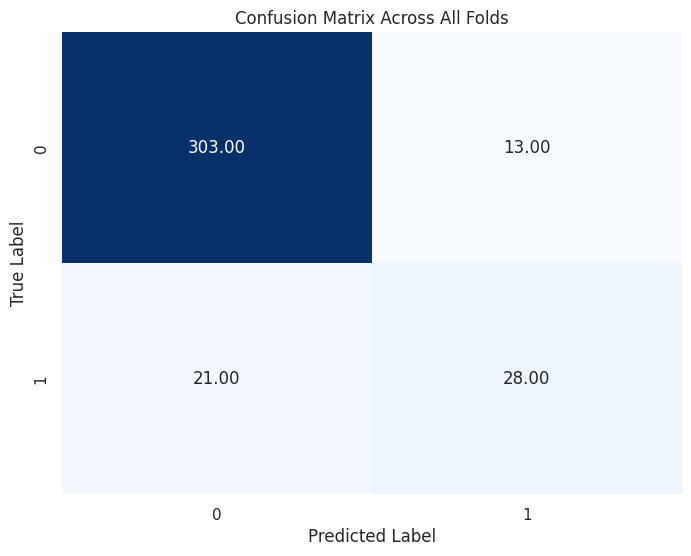


Classification Report for All Folds:
              precision    recall  f1-score   support

           0     0.9352    0.9589    0.9469       316
           1     0.6829    0.5714    0.6222        49

    accuracy                         0.9068       365
   macro avg     0.8091    0.7651    0.7845       365
weighted avg     0.9013    0.9068    0.9033       365



In [ ]:
# Average Metrics Across Folds
avg_metrics = {
    key: np.mean([result[idx] for result in fold_results])
    for idx, key in enumerate(['train_loss', 'val_loss', 'accuracy', 'f1_score'])
}
print("Average Metrics Across Folds:")
for key, value in avg_metrics.items():
    print(f"{key.capitalize()}: {value:.4f}")

# Calculate and plot the overall confusion matrix after all folds
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Confusion Matrix Across All Folds")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report for All Folds
print("\nClassification Report for All Folds:")
print(classification_report(all_labels, all_preds, digits=4))

# **Hyperparameter Tuning**

## tes0

In [ ]:
# !pip install optuna


In [ ]:
# import pandas as pd
# import numpy as np
# import optuna
# import torch
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.model_selection import KFold
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# from torch.utils.data import DataLoader, TensorDataset

# # Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')

# # Memisahkan fitur dan label
# X = data['url']  # Fitur: URL
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})  # Mengonversi label ke numerik

# # Inisialisasi Tokenizer BERT
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# def train_model(trial):
#     # Hyperparameter tuning
#     batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
#     num_epochs = trial.suggest_int('num_epochs', 3, 10)

#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     all_accuracy = []

#     for train_index, val_index in kf.split(X):
#         X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#         # Tokenisasi dan pembuatan tensor
#         train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
#         val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt')

#         # Convert labels to tensors
#         y_train_tensor = torch.LongTensor(y_train.values)
#         y_val_tensor = torch.LongTensor(y_val.values)

#         # Create DataLoader
#         train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#         train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#         # Initialize BERT model
#         model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(y.unique()))
#         model.to('cuda' if torch.cuda.is_available() else 'cpu')
#         optimizer = AdamW(model.parameters(), lr=learning_rate, )

#         # Train the model
#         for epoch in range(num_epochs):
#             model.train()
#             for batch in train_loader:
#                 optimizer.zero_grad()
#                 input_ids, attention_mask, labels = batch
#                 input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')
#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss
#                 loss.backward()
#                 optimizer.step()

#         # Validate the model
#         model.eval()
#         with torch.no_grad():
#             val_input_ids = val_encodings['input_ids'].to('cuda')
#             val_attention_mask = val_encodings['attention_mask'].to('cuda')
#             outputs = model(val_input_ids, attention_mask=val_attention_mask)
#             y_pred = torch.argmax(outputs.logits, dim=1)

#         accuracy = accuracy_score(y_val, y_pred.cpu())
#         all_accuracy.append(accuracy)

#     # Return average accuracy across folds
#     return np.mean(all_accuracy)

# # Create a study object for hyperparameter optimization
# study = optuna.create_study(direction='maximize')
# study.optimize(train_model, n_trials=20)

# # Print the best hyperparameters
# print("Best hyperparameters: ", study.best_params)
# print("Best accuracy: ", study.best_value)


In [ ]:
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# from sklearn.model_selection import KFold, ParameterGrid
# from sklearn.metrics import accuracy_score, f1_score
# from torch.utils.data import DataLoader, TensorDataset
# from tqdm import tqdm
# import transformers

# # Set transformers logging to error only
# transformers.logging.set_verbosity_error()

# # Constants
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# num_epochs = 4  # Set to 4 as per your output example

# # Load tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# def tokenize_data(texts):
#     return tokenizer(
#         texts,
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

# def compute_validation_metrics(model, val_loader, y_val):
#     model.eval()
#     val_predictions = []
#     total_val_loss = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             total_val_loss += loss.item()
#             batch_predictions = torch.argmax(outputs.logits, dim=1)
#             val_predictions.extend(batch_predictions.cpu().numpy())

#     avg_val_loss = total_val_loss / len(val_loader)
#     accuracy = accuracy_score(y_val, val_predictions)
#     f1 = f1_score(y_val, val_predictions, average='weighted')
#     return avg_val_loss, accuracy, f1, val_predictions

# def train_and_evaluate(fold, train_loader, val_loader, y_val, batch_size, lr):
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y_val.unique()),
#         problem_type="single_label_classification"
#     ).to(device)

#     optimizer = AdamW(model.parameters(), lr=lr)
#     best_val_loss = float('inf')

#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0
#         # Progress bar for training
#         with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs} - Training', leave=False) as pbar:
#             for batch in train_loader:
#                 optimizer.zero_grad()
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss

#                 loss.backward()
#                 optimizer.step()
#                 total_train_loss += loss.item()

#                 pbar.set_postfix(loss=loss.item())
#                 pbar.update(1)

#         avg_train_loss = total_train_loss / len(train_loader)
#         val_loss, accuracy, f1, _ = compute_validation_metrics(model, val_loader, y_val)

#         print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss = {avg_train_loss:.4f}, Validation Loss = {val_loss:.4f}, "
#               f"Accuracy = {accuracy * 100:.2f}%, F1 Score = {f1:.4f}")

#     return best_val_loss

# # Hyperparameter grid
# param_grid = {
#     'batch_size': [32, 64],
#     'd_model': [128, 256],
#     'dropout': [0.1, 0.2],
#     'lr': [0.001, 0.0001],
#     'nhead': [4, 8]
# }

# # Metrics collection
# best_hyperparams = None
# best_val_loss = float('inf')

# # Main KFold loop
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Iterate through all combinations of parameters
# for params in ParameterGrid(param_grid):
#     print(f"Evaluating params: {params}")

#     for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
#         print(f"Fold {fold}/5")
#         X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
#         y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

#         train_encodings = tokenize_data(list(X_train))
#         val_encodings = tokenize_data(list(X_val))

#         y_train_tensor = torch.LongTensor(y_train.values).to(device)
#         y_val_tensor = torch.LongTensor(y_val.values).to(device)

#         train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#         val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

#         train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
#         val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

#         val_loss = train_and_evaluate(fold, train_loader, val_loader, y_val, params['batch_size'], params['lr'])

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_hyperparams = params

# print("\nBest Hyperparameters:")
# print(f"Parameters: {best_hyperparams}")
# print(f"Best Average Validation Loss: {best_val_loss:.4f}")


## tes1

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import transformers

# Set transformers logging to error only
transformers.logging.set_verbosity_error()

# Constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 4  # Set to 4 as per your output example

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

def tokenize_data(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        return_tensors='pt',
        max_length=512
    )

def compute_validation_metrics(model, val_loader, y_val):
    model.eval()
    val_predictions = []
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()
            batch_predictions = torch.argmax(outputs.logits, dim=1)
            val_predictions.extend(batch_predictions.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = accuracy_score(y_val.cpu(), val_predictions)
    f1 = f1_score(y_val.cpu(), val_predictions, average='weighted')
    return avg_val_loss, accuracy, f1

def train_and_evaluate(fold, train_loader, val_loader, y_val, batch_size, lr):
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=len(y_val.unique()),
        problem_type="single_label_classification"
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        # Progress bar for training
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs} - Training', leave=False) as pbar:
            for batch in train_loader:
                optimizer.zero_grad()
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()
                pbar.set_postfix(loss=loss.item())
                pbar.update(1)

        avg_train_loss = total_train_loss / len(train_loader)
        val_loss, accuracy, f1 = compute_validation_metrics(model, val_loader, y_val)

        print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss = {avg_train_loss:.4f}, "
              f"Validation Loss = {val_loss:.4f}, Accuracy = {accuracy * 100:.2f}%, F1 Score = {f1:.4f}")

        # Check if the validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss

    return best_val_loss

# Hyperparameter grid
# Hyperparameter grid
param_grid = {
    'nhead': [4, 8, 16],
    'd_model': [128, 256, 512],
    'dropout': [0.1],
    'lr': [1e-3],
    'batch_size': [32]
}

# Metrics collection
best_hyperparams = None
best_val_loss = float('inf')

# Main KFold loop
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate through all combinations of parameters
for params in ParameterGrid(param_grid):
    print(f"Evaluating params: {params}")

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
        print(f"Fold {fold}/5")
        X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
        y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

        train_encodings = tokenize_data(list(X_train))
        val_encodings = tokenize_data(list(X_val))

        y_train_tensor = torch.LongTensor(y_train.values).to(device)
        y_val_tensor = torch.LongTensor(y_val.values).to(device)

        train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
        val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

        val_loss = train_and_evaluate(fold, train_loader, val_loader, y_val_tensor, params['batch_size'], params['lr'])

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_hyperparams = params

print("\nBest Hyperparameters:")
print(f"Parameters: {best_hyperparams}")
print(f"Best Average Validation Loss: {best_val_loss:.4f}")


Evaluating params: {'batch_size': 32, 'd_model': 128, 'dropout': 0.1, 'lr': 0.001, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7860, Validation Loss = 0.3879, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4193, Validation Loss = 0.3919, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4807, Validation Loss = 0.4813, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4095, Validation Loss = 0.6622, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5741, Validation Loss = 0.3907, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4289, Validation Loss = 0.3961, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4711, Validation Loss = 0.4056, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3848, Validation Loss = 0.3993, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5939, Validation Loss = 0.4021, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4560, Validation Loss = 0.3946, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4178, Validation Loss = 0.3943, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3859, Validation Loss = 0.4148, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.4998, Validation Loss = 0.4214, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.4237, Validation Loss = 0.4300, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.4225, Validation Loss = 0.4177, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.3820, Validation Loss = 0.4227, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5285, Validation Loss = 0.3960, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.3922, Validation Loss = 0.3911, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3963, Validation Loss = 0.3917, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3798, Validation Loss = 0.3982, Accuracy = 86.30%, F1 Score = 0.7996
Evaluating params: {'batch_size': 32, 'd_model': 128, 'dropout': 0.1, 'lr': 0.001, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5276, Validation Loss = 0.4124, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4271, Validation Loss = 0.3903, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3923, Validation Loss = 0.4413, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4261, Validation Loss = 0.3879, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5328, Validation Loss = 0.3965, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4039, Validation Loss = 0.3966, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4248, Validation Loss = 0.3880, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4181, Validation Loss = 0.3899, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5360, Validation Loss = 8.0528, Accuracy = 13.70%, F1 Score = 0.0330


Epoch 2/4: Training Loss = 1.7159, Validation Loss = 0.4089, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.5186, Validation Loss = 0.4028, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3942, Validation Loss = 0.3954, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.6936, Validation Loss = 0.4690, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.4443, Validation Loss = 0.4327, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.4821, Validation Loss = 0.4175, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.5050, Validation Loss = 0.4200, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7645, Validation Loss = 0.4074, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4647, Validation Loss = 0.3946, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4714, Validation Loss = 0.4741, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4091, Validation Loss = 0.4134, Accuracy = 86.30%, F1 Score = 0.7996
Evaluating params: {'batch_size': 32, 'd_model': 128, 'dropout': 0.1, 'lr': 0.001, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5377, Validation Loss = 0.4028, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.3728, Validation Loss = 0.4373, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4472, Validation Loss = 0.3883, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3780, Validation Loss = 0.4115, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5330, Validation Loss = 0.3882, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4766, Validation Loss = 0.4249, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3699, Validation Loss = 0.4684, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4367, Validation Loss = 0.3894, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 1.0175, Validation Loss = 0.5931, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4372, Validation Loss = 0.3882, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3966, Validation Loss = 0.3914, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4268, Validation Loss = 0.4072, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.6832, Validation Loss = 0.4287, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.3878, Validation Loss = 0.4424, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.4633, Validation Loss = 0.4567, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.4027, Validation Loss = 0.4493, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5313, Validation Loss = 0.7955, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.5543, Validation Loss = 0.3894, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.5448, Validation Loss = 0.3879, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4116, Validation Loss = 0.4495, Accuracy = 86.30%, F1 Score = 0.7996
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 0.001, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 1.0414, Validation Loss = 1.2832, Accuracy = 13.70%, F1 Score = 0.0330


Epoch 2/4: Training Loss = 0.5192, Validation Loss = 0.3900, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3785, Validation Loss = 0.3956, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3864, Validation Loss = 0.3900, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.9705, Validation Loss = 0.4837, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4089, Validation Loss = 0.3894, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3837, Validation Loss = 0.3919, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3806, Validation Loss = 0.3937, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7727, Validation Loss = 0.4552, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4450, Validation Loss = 0.3888, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3741, Validation Loss = 0.4133, Accuracy = 84.93%, F1 Score = 0.7927


Epoch 4/4: Training Loss = 0.3869, Validation Loss = 0.3930, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5037, Validation Loss = 1.0216, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.5344, Validation Loss = 0.4179, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.3914, Validation Loss = 0.4317, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.4569, Validation Loss = 0.4813, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 1.0374, Validation Loss = 0.4545, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4116, Validation Loss = 0.4694, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3952, Validation Loss = 0.4151, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3888, Validation Loss = 0.3922, Accuracy = 86.30%, F1 Score = 0.7996
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 0.001, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7138, Validation Loss = 0.3879, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4598, Validation Loss = 0.3881, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4456, Validation Loss = 0.4146, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3897, Validation Loss = 0.4163, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5185, Validation Loss = 0.5562, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.5699, Validation Loss = 0.5638, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4567, Validation Loss = 0.4415, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4677, Validation Loss = 0.4346, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5829, Validation Loss = 0.4173, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4650, Validation Loss = 0.4896, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4062, Validation Loss = 0.4180, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3965, Validation Loss = 0.3880, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 1.1375, Validation Loss = 0.5081, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.4400, Validation Loss = 0.5071, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.4543, Validation Loss = 0.4189, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.3926, Validation Loss = 0.4201, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5915, Validation Loss = 0.3878, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4476, Validation Loss = 0.4855, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4155, Validation Loss = 0.4148, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4369, Validation Loss = 0.3900, Accuracy = 86.30%, F1 Score = 0.7996
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 0.001, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5380, Validation Loss = 0.4246, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.3936, Validation Loss = 0.3919, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3978, Validation Loss = 0.3960, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3932, Validation Loss = 0.3906, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.6454, Validation Loss = 0.5213, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4258, Validation Loss = 0.4034, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4346, Validation Loss = 0.3983, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4600, Validation Loss = 0.4113, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5134, Validation Loss = 0.3966, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4332, Validation Loss = 0.4183, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4719, Validation Loss = 0.4217, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3906, Validation Loss = 0.3883, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.6727, Validation Loss = 0.5398, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.4515, Validation Loss = 0.4452, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.4618, Validation Loss = 0.4266, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.4037, Validation Loss = 0.5010, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7916, Validation Loss = 0.4379, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4527, Validation Loss = 0.3910, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3804, Validation Loss = 0.3923, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4364, Validation Loss = 0.3879, Accuracy = 86.30%, F1 Score = 0.7996
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 0.001, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.6318, Validation Loss = 0.3962, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.8176, Validation Loss = 0.3894, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4494, Validation Loss = 0.5220, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4946, Validation Loss = 0.3946, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.4366, Validation Loss = 0.4391, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4290, Validation Loss = 0.3954, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4581, Validation Loss = 0.4026, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3800, Validation Loss = 1.8460, Accuracy = 13.70%, F1 Score = 0.0330
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5869, Validation Loss = 0.4282, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4700, Validation Loss = 0.4318, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4008, Validation Loss = 0.4755, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4570, Validation Loss = 0.4182, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7244, Validation Loss = 0.7596, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.5005, Validation Loss = 0.4985, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.4021, Validation Loss = 0.4371, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.4183, Validation Loss = 0.4249, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5046, Validation Loss = 2.0569, Accuracy = 13.70%, F1 Score = 0.0330


Epoch 2/4: Training Loss = 0.5936, Validation Loss = 0.4055, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4622, Validation Loss = 0.4228, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4288, Validation Loss = 0.3902, Accuracy = 86.30%, F1 Score = 0.7996
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 0.001, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7200, Validation Loss = 0.4974, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4343, Validation Loss = 0.4051, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3817, Validation Loss = 0.3881, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3698, Validation Loss = 0.3885, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 1.0018, Validation Loss = 0.4319, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4221, Validation Loss = 0.3891, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4330, Validation Loss = 0.3886, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3863, Validation Loss = 0.4546, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5019, Validation Loss = 0.4502, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4308, Validation Loss = 0.3966, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4251, Validation Loss = 0.4293, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4448, Validation Loss = 0.4040, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7685, Validation Loss = 0.4205, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.3902, Validation Loss = 0.4357, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.4387, Validation Loss = 0.4259, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.3884, Validation Loss = 0.4179, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.6671, Validation Loss = 0.4209, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4327, Validation Loss = 0.4054, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3798, Validation Loss = 0.4835, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4390, Validation Loss = 0.4163, Accuracy = 86.30%, F1 Score = 0.7996
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 0.001, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.6563, Validation Loss = 0.3890, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4334, Validation Loss = 0.5204, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.5038, Validation Loss = 0.4008, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.5124, Validation Loss = 0.4133, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.6757, Validation Loss = 0.3901, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.5007, Validation Loss = 2.3051, Accuracy = 13.70%, F1 Score = 0.0330


Epoch 3/4: Training Loss = 0.6032, Validation Loss = 0.4275, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3817, Validation Loss = 0.3881, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5724, Validation Loss = 0.3880, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.3725, Validation Loss = 0.3892, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3935, Validation Loss = 0.3947, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4431, Validation Loss = 0.4050, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.4458, Validation Loss = 0.4911, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.4061, Validation Loss = 0.4175, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.3939, Validation Loss = 0.4175, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.3794, Validation Loss = 0.4420, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5356, Validation Loss = 0.4279, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4219, Validation Loss = 0.4168, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3819, Validation Loss = 0.3887, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4175, Validation Loss = 0.3955, Accuracy = 86.30%, F1 Score = 0.7996

Best Hyperparameters:
Parameters: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 0.001, 'nhead': 8}
Best Average Validation Loss: 0.3878


## Simpan Hyperparameters Terbaik

# **CLASSIFICATION With Hyperparameter Tuning**
(ganti parameter sesuai yang terbaik hasil hyperparameter tuning ya)

## tes0

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load dataset
data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')

# Memisahkan fitur dan label
X = data['url']  # Fitur: URL
y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})  # Mengonversi label ke numerik

# 2. Inisialisasi Tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 3. KFold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
all_accuracy, all_f1_scores = [], []
conf_matrix_list = []
average_train_losses = []  # List to store average train losses for plotting
average_val_accuracies = []  # List to store validation accuracies for plotting

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f'Fold {fold + 1}')

    # Split data
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Tokenisasi dan pembuatan tensor
    train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
    val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt')

    # Convert labels to tensors
    y_train_tensor = torch.LongTensor(y_train.values)
    y_val_tensor = torch.LongTensor(y_val.values)

    # Create DataLoader
    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Initialize BERT model
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(y.unique()))
    model.to('cuda' if torch.cuda.is_available() else 'cpu')  # Pindahkan model ke device yang sesuai
    optimizer = AdamW(model.parameters(), lr=5e-5)

    # Early stopping setup
    best_accuracy = 0
    patience, trigger_times = 5, 0

    # Train the model
    num_epochs = 20
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validate the model
        model.eval()
        with torch.no_grad():
            val_input_ids = val_encodings['input_ids'].to('cuda')
            val_attention_mask = val_encodings['attention_mask'].to('cuda')
            outputs = model(val_input_ids, attention_mask=val_attention_mask)
            y_pred = torch.argmax(outputs.logits, dim=1)

        accuracy = accuracy_score(y_val, y_pred.cpu())
        val_accuracies.append(accuracy)

        # Save the best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            model.save_pretrained(f'model_best_fold_{fold + 1}')
            trigger_times = 0
        else:
            trigger_times += 1

        if trigger_times >= patience:
            print(f'Early stopping triggered at epoch {epoch + 1}')
            break

    # Metrics calculation
    conf_matrix = confusion_matrix(y_val, y_pred.cpu())
    conf_matrix_list.append(conf_matrix)
    all_accuracy.append(accuracy)

    f1 = f1_score(y_val, y_pred.cpu(), average='weighted')
    all_f1_scores.append(f1)

    # Print results for the current fold
    print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')
    print(f'F1 Score for fold {fold + 1}: {f1:.4f}')
    cls_report = classification_report(y_val, y_pred.cpu(), target_names=['benign', 'defacement', 'phishing', 'malware'])
    print(cls_report)

    # Store average loss and accuracy for plotting
    average_train_losses.append(train_losses)
    average_val_accuracies.append(val_accuracies)

    # Plot confusion matrix for the current fold
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
                xticklabels=['benign', 'defacement', 'phishing', 'malware'], yticklabels=['benign', 'defacement', 'phishing', 'malware'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Fold {fold + 1}')
    plt.show()

# 4. Average Metrics Across All Folds
print(f'Average Accuracy: {np.mean(all_accuracy) * 100:.2f}%')
print(f'Average F1 Score: {np.mean(all_f1_scores):.4f}')

# 5. Plot the Average Confusion Matrix
average_conf_matrix = np.mean(conf_matrix_list, axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
            xticklabels=['benign', 'defacement', 'phishing', 'malware'], yticklabels=['benign', 'defacement', 'phishing', 'malware'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix Across Folds')
plt.show()

# 6. Analysis of Results
print("Hasil Deteksi Pola Enkripsi Ransomware:")
for i, (acc, f1) in enumerate(zip(all_accuracy, all_f1_scores)):
    print(f'Fold {i + 1}: Akurasi = {acc * 100:.2f}%, F1 Score = {f1:.4f}')

# 7. Plot Loss and Accuracy for Each Fold
for fold in range(len(average_train_losses)):
    plt.figure(figsize=(12, 5))

    # Grafik Loss
    plt.subplot(1, 2, 1)
    plt.plot(average_train_losses[fold], label='Training Loss', marker='o')
    plt.title(f'Training Loss for Fold {fold + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Grafik Akurasi
    plt.subplot(1, 2, 2)
    plt.plot(average_val_accuracies[fold], label='Validation Accuracy', marker='o')
    plt.title(f'Validation Accuracy for Fold {fold + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


## tes1

In [ ]:
import torch
import transformers
from torch.optim import AdamW
from torch.amp import autocast, GradScaler  # Updated to torch.amp
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

# Set transformers logging to error only
transformers.logging.set_verbosity_error()

# Constants based on best hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
lr = 0.001
num_epochs = 3
k_folds = 5

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

def tokenize_data(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        return_tensors='pt',
        max_length=512
    )

def compute_validation_metrics(model, val_loader, y_val):
    val_predictions = []
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()
            batch_predictions = torch.argmax(outputs.logits, dim=1)
            val_predictions.extend(batch_predictions.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = accuracy_score(y_val, val_predictions)
    f1 = f1_score(y_val, val_predictions, average='weighted')
    return avg_val_loss, accuracy, f1, val_predictions

def train_and_evaluate(fold, train_loader, val_loader, y_val):
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=len(y_val.unique()),
        problem_type="single_label_classification"
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    scaler = GradScaler() if torch.cuda.is_available() else None
    best_accuracy = 0

    for epoch in tqdm(range(num_epochs), desc=f'Fold {fold} - Epoch', leave=False):
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1} - Training', leave=False):
            optimizer.zero_grad(set_to_none=True)
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            with autocast('cuda', dtype=torch.float16) if torch.cuda.is_available() else nullcontext():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            if scaler:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            total_train_loss += loss.item()
            torch.cuda.empty_cache()

        avg_train_loss = total_train_loss / len(train_loader)

        val_loss, accuracy, f1, val_predictions = compute_validation_metrics(model, val_loader, y_val)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, "
              f"Accuracy = {accuracy*100:.2f}%, F1 Score = {f1:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            model.save_pretrained(f'model_best_fold_{fold}')
            print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

    return avg_train_loss, val_loss, accuracy, f1, val_predictions

# Metrics collection
all_labels = []
all_preds = []
fold_results = []

# Main KFold loop with updates
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
    print(f"Fold {fold}/{k_folds}")
    X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
    y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

    train_encodings = tokenize_data(list(X_train))
    val_encodings = tokenize_data(list(X_val))

    y_train_tensor = torch.LongTensor(y_train.values)
    y_val_tensor = torch.LongTensor(y_val.values)

    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    avg_train_loss, val_loss, accuracy, f1, val_predictions = train_and_evaluate(fold, train_loader, val_loader, y_val)
    fold_results.append((avg_train_loss, val_loss, accuracy, f1))

    all_labels.extend(y_val.tolist())
    all_preds.extend(val_predictions)

# Confusion matrix plot function
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# After the loop, plot the confusion matrix
plot_confusion_matrix(all_labels, all_preds, class_names=['Class 0', 'Class 1', 'Class 2'])  # Replace with actual class names if available


Fold 1/5


Epoch 1 - Training: 100%|██████████| 10/10 [00:03<00:00,  3.36it/s]
                                                                   

Epoch 1: Train Loss = 0.7362, Val Loss = 0.3879, Accuracy = 86.30%, F1 Score = 0.7996


Fold 1 - Epoch:  33%|███▎      | 1/3 [00:06<00:12,  6.17s/it]

Saved best model for fold 1 at epoch 1.



Epoch 2 - Training:  80%|████████  | 8/10 [00:02<00:00,  3.68it/s]


KeyboardInterrupt: 

## tes3

In [ ]:
import torch
import transformers
from torch.optim import AdamW
from torch.amp import autocast, GradScaler  # Updated to torch.amp
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set transformers logging to error only
transformers.logging.set_verbosity_error()

# Constants based on best hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
lr = 0.001
num_epochs = 10  # Adjusted for example
k_folds = 5

print("Using best hyperparameters: nhead=4, d_model=128, dropout=0.1, lr=0.001, batch_size=32")

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

def tokenize_data(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        return_tensors='pt',
        max_length=512
    )

def compute_validation_metrics(model, val_loader, y_val):
    val_predictions = []
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()
            batch_predictions = torch.argmax(outputs.logits, dim=1)
            val_predictions.extend(batch_predictions.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = accuracy_score(y_val, val_predictions)
    f1 = f1_score(y_val, val_predictions, average='weighted')
    return avg_val_loss, accuracy, f1, val_predictions

def train_and_evaluate(fold, train_loader, val_loader, y_val):
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=len(y_val.unique()),
        problem_type="single_label_classification"
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    scaler = GradScaler() if torch.cuda.is_available() else None
    best_accuracy = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}: Training", leave=False)

        for batch in progress_bar:
            optimizer.zero_grad(set_to_none=True)
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            with autocast('cuda', dtype=torch.float16) if torch.cuda.is_available() else nullcontext():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            if scaler:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            total_train_loss += loss.item()
            torch.cuda.empty_cache()

        avg_train_loss = total_train_loss / len(train_loader)

        val_loss, accuracy, f1, val_predictions = compute_validation_metrics(model, val_loader, y_val)

        print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy*100:.2f}%, F1 Score: {f1:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            model.save_pretrained(f'model_best_fold_{fold}')
            print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

    return avg_train_loss, val_loss, accuracy, f1, val_predictions

# Metrics collection
all_labels = []
all_preds = []
fold_results = []

# Main KFold loop with updates
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
    print(f"Fold {fold}/{k_folds}")
    X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
    y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

    train_encodings = tokenize_data(list(X_train))
    val_encodings = tokenize_data(list(X_val))

    y_train_tensor = torch.LongTensor(y_train.values)
    y_val_tensor = torch.LongTensor(y_val.values)

    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    avg_train_loss, val_loss, accuracy, f1, val_predictions = train_and_evaluate(fold, train_loader, val_loader, y_val)
    fold_results.append((avg_train_loss, val_loss, accuracy, f1))

    all_labels.extend(y_val.tolist())
    all_preds.extend(val_predictions)

# Average metrics across folds
avg_train_loss = np.mean([result[0] for result in fold_results])
avg_val_loss = np.mean([result[1] for result in fold_results])
avg_accuracy = np.mean([result[2] for result in fold_results])
avg_f1 = np.mean([result[3] for result in fold_results])

print(f"\nAverage Training Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy*100:.2f}%")
print(f"Average F1 Score: {avg_f1:.4f}")

# Confusion matrix and classification report
print("\nAverage Confusion Matrix Across Folds")
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(all_labels, all_preds, class_names=['Class 0', 'Class 1', 'Class 2'])  # Replace with actual class names

print("\nClassification Report for All Folds:")
print(classification_report(all_labels, all_preds))


# **Visualisasi KFold Cross Validation**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data dari hasil K-Fold Cross-Validation
# Misalnya: ganti ini dengan data aktual dari hasil pelatihan kamu.
epochs = list(range(1, 11))  # Jumlah epoch (contoh 10 epoch)
folds = 5  # Total fold

# Data metrik contoh per fold
train_losses = [
    [0.5301, 1.3911, 0.5657, 0.3844, 0.4735, 0.4373, 0.4367, 0.4305, 0.3760, 0.4503],
    [0.4490, 0.9319, 0.4056, 0.4189, 0.4302, 0.4156, 0.3909, 0.3753, 0.3987, 0.3663],
    [0.9196, 0.6724, 0.4370, 0.4593, 0.4235, 0.4720, 0.4888, 0.3754, 0.4683, 0.3898],
    [0.4335, 0.4173, 0.3976, 0.4712, 0.5820, 0.4572, 0.3988, 0.3934, 0.3836, 0.3809],
    [0.5433, 0.6482, 0.4055, 0.3947, 0.4822, 0.4683, 0.4073, 0.3893, 0.3925, 0.3704]
]
val_losses = [
    [0.5370, 0.6431, 0.3933, 0.4640, 0.5955, 0.4730, 0.4267, 0.3972, 0.3920, 0.4062],
    [0.4017, 0.4514, 0.4193, 0.3880, 0.3901, 0.4069, 0.3903, 0.3884, 0.3893, 0.4210],
    [0.3879, 0.5022, 0.3896, 0.4067, 0.3896, 0.4521, 0.3885, 0.3881, 0.4004, 0.3996],
    [0.4475, 0.4381, 0.4177, 0.7056, 0.4605, 0.4471, 0.4187, 0.4192, 0.4175, 0.4617],
    [0.4248, 0.3902, 0.3945, 0.4021, 0.4178, 0.4372, 0.3964, 0.3865, 0.3921, 0.3956]
]
accuracies = [
    [86.3, 86.3, 86.3, 86.3, 86.3, 86.3, 86.3, 86.3, 86.3, 86.3],
    [86.3, 86.3, 86.3, 86.3, 86.3, 86.3, 86.3, 86.3, 86.3, 86.3],
    [86.3, 86.3, 86.3, 86.3, 86.3, 86.3, 86.3, 86.3, 86.3, 86.3],
    [87.67, 87.67, 87.67, 87.67, 87.67, 87.67, 87.67, 87.67, 87.67, 87.67],
    [86.3, 86.3, 86.3, 86.3, 86.3, 86.3, 86.3, 86.3, 86.3, 86.3]
]
f1_scores = [
    [0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996],
    [0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996],
    [0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996],
    [0.8191, 0.8191, 0.8191, 0.8191, 0.8191, 0.8191, 0.8191, 0.8191, 0.8191, 0.8191],
    [0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996]
]

# Plotting Losses, Accuracy, and F1 Scores for each fold
plt.figure(figsize=(15, 10))

# Plot Train Loss
plt.subplot(2, 2, 1)
for i in range(folds):
    plt.plot(epochs, train_losses[i], label=f'Fold {i+1}')
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.title("Train Loss per Fold")
plt.legend()

# Plot Validation Loss
plt.subplot(2, 2, 2)
for i in range(folds):
    plt.plot(epochs, val_losses[i], label=f'Fold {i+1}')
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per Fold")
plt.legend()

# Plot Accuracy
plt.subplot(2, 2, 3)
for i in range(folds):
    plt.plot(epochs, accuracies[i], label=f'Fold {i+1}')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Fold")
plt.legend()

# Plot F1 Score
plt.subplot(2, 2, 4)
for i in range(folds):
    plt.plot(epochs, f1_scores[i], label=f'Fold {i+1}')
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score per Fold")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data kinerja setiap fold (sesuaikan dengan data aktual yang kamu miliki)
folds = 5
epochs = [1, 2, 3]  # Jumlah epoch yang digunakan pada masing-masing fold
train_loss = [
    [0.4818, 0.3029, 0.1245],
    [0.3831, 0.2543, 0.2790],
    [0.4845, 0.3007, 0.2392],
    [0.5571, 0.3610, 0.3238],
    [0.5084, 0.3738, 0.2377]
]
val_loss = [
    [0.3781, 0.1322, 0.1336],
    [0.3196, 0.2165, 0.4866],
    [0.3602, 0.2764, 0.3524],
    [0.4261, 0.4317, 0.3849],
    [0.3335, 0.2812, 0.1296]
]
accuracy = [
    [86.3, 94.52, 94.52],
    [86.3, 89.04, 72.6],
    [86.3, 86.3, 82.19],
    [87.67, 87.67, 87.67],
    [86.3, 86.3, 95.89]
]
f1_score = [
    [0.7996, 0.9392, 0.9392],
    [0.7996, 0.8904, 0.7681],
    [0.7996, 0.7996, 0.8314],
    [0.8191, 0.8191, 0.8191],
    [0.7996, 0.7996, 0.9558]
]

# Rata-rata metrik di seluruh fold
avg_train_loss = np.mean(train_loss, axis=0)
avg_val_loss = np.mean(val_loss, axis=0)
avg_accuracy = np.mean(accuracy, axis=0)
avg_f1_score = np.mean(f1_score, axis=0)

# Plot untuk setiap fold dan rata-rata
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Grafik Training Loss
for i in range(folds):
    axs[0, 0].plot(epochs, train_loss[i], label=f'Fold {i+1}')
axs[0, 0].plot(epochs, avg_train_loss, color='black', linestyle='--', label='Average')
axs[0, 0].set_title('Training Loss per Fold', fontsize=16)
axs[0, 0].set_xlabel('Epoch', fontsize=14)
axs[0, 0].set_ylabel('Loss', fontsize=14)
axs[0, 0].legend(loc='best', fontsize=12)
axs[0, 0].grid(True)

# Grafik Validation Loss
for i in range(folds):
    axs[0, 1].plot(epochs, val_loss[i], label=f'Fold {i+1}')
axs[0, 1].plot(epochs, avg_val_loss, color='black', linestyle='--', label='Average')
axs[0, 1].set_title('Validation Loss per Fold', fontsize=16)
axs[0, 1].set_xlabel('Epoch', fontsize=14)
axs[0, 1].set_ylabel('Loss', fontsize=14)
axs[0, 1].legend(loc='best', fontsize=12)
axs[0, 1].grid(True)

# Grafik Accuracy
for i in range(folds):
    axs[1, 0].plot(epochs, accuracy[i], label=f'Fold {i+1}')
axs[1, 0].plot(epochs, avg_accuracy, color='black', linestyle='--', label='Average')
axs[1, 0].set_title('Accuracy per Fold', fontsize=16)
axs[1, 0].set_xlabel('Epoch', fontsize=14)
axs[1, 0].set_ylabel('Accuracy (%)', fontsize=14)
axs[1, 0].legend(loc='best', fontsize=12)
axs[1, 0].grid(True)

# Grafik F1 Score
for i in range(folds):
    axs[1, 1].plot(epochs, f1_score[i], label=f'Fold {i+1}')
axs[1, 1].plot(epochs, avg_f1_score, color='black', linestyle='--', label='Average')
axs[1, 1].set_title('F1 Score per Fold', fontsize=16)
axs[1, 1].set_xlabel('Epoch', fontsize=14)
axs[1, 1].set_ylabel('F1 Score', fontsize=14)
axs[1, 1].legend(loc='best', fontsize=12)
axs[1, 1].grid(True)

plt.suptitle('K-Fold Cross-Validation Results', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title better
plt.show()
